In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time,math,csv
import itertools
import collections

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# geo
import fiona
import shapely.geometry
from rtree import index

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

## Load flooding per block group

In [2]:
def load_bg_flood_data(slr_amount):
    f = open("data/slr_%dft_bg_intersection.csv" % (slr_amount), "r")
    header_line = f.readline().strip().split(",")
    data = {}
    for line in f:
        line = line.strip()
        if line != "":
            parts = line.split(",")
            geoid = parts[0]
            total_area = int(parts[1])
            flooded_area = int(parts[2])
            percent_flooded = float(parts[3])
            data[geoid] = percent_flooded
    f.close()
    
    return data

In [3]:
flood_data = [
    load_bg_flood_data(i) for i in range(7)
]

In [4]:
len(flood_data)

7

## Load population per block group

In [5]:
def load_bg_population_data(year):
    f = open("data/regression_estimated_population.csv", "r")
    header_line = f.readline().strip().split(",")
    data = {}
    
    year_index = None
    for i in range(2, len(header_line)):
        if int(header_line[i]) == year:
            year_index = i
            break
    if year_index is None:
        raise ValueError("year must be between 2010 and 2100")
    
    for line in f:
        line = line.strip()
        if line != "":
            parts = line.split(",")
            geoid = parts[1]
            population = float(parts[year_index])
            data[geoid] = population
    f.close()

    return data

In [6]:
population_data = load_bg_population_data(2050)

In [7]:
len(population_data)

216330

## Load block group --> county mapping

In [6]:
f = open("data/regression_estimated_population.csv", "r")
header_line = f.readline().strip().split(",")
bg_to_county = {}
for line in f:
    line = line.strip()
    if line != "":
        parts = line.split(",")
        county_id = parts[0]
        bg_id = parts[1]
        bg_to_county[bg_id] = county_id
f.close()

block_groups = sorted(bg_to_county.keys())
counties = sorted(bg_to_county.values())
counties_to_index = {county: i for i, county in enumerate(counties)}

bg_to_county_index = {}
for k,v in bg_to_county.items():
    bg_to_county_index[k] = counties_to_index[v]

## Visualize flooded population

In [9]:
shapefileFn = "data/boundary_shapefiles/cb_2013_us_county_20m/cb_2013_us_county_20m.shp"
shapefileKey = "GEOID"

In [10]:
flooded_populations = [
    np.zeros((len(counties)), dtype=float) for i in range(len(flood_data))
]

for i in range(len(flood_data)):
    for bg_id in block_groups:
        flooded_population = population_data[bg_id] * flood_data[i][bg_id]
        county_id = bg_to_county_index[bg_id]
        flooded_populations[i][county_id] += flooded_population

In [11]:
def vector_to_labeled_dict(data, labels):
    return {
        labels[i]: data[i] for i in range(len(labels))
    }

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


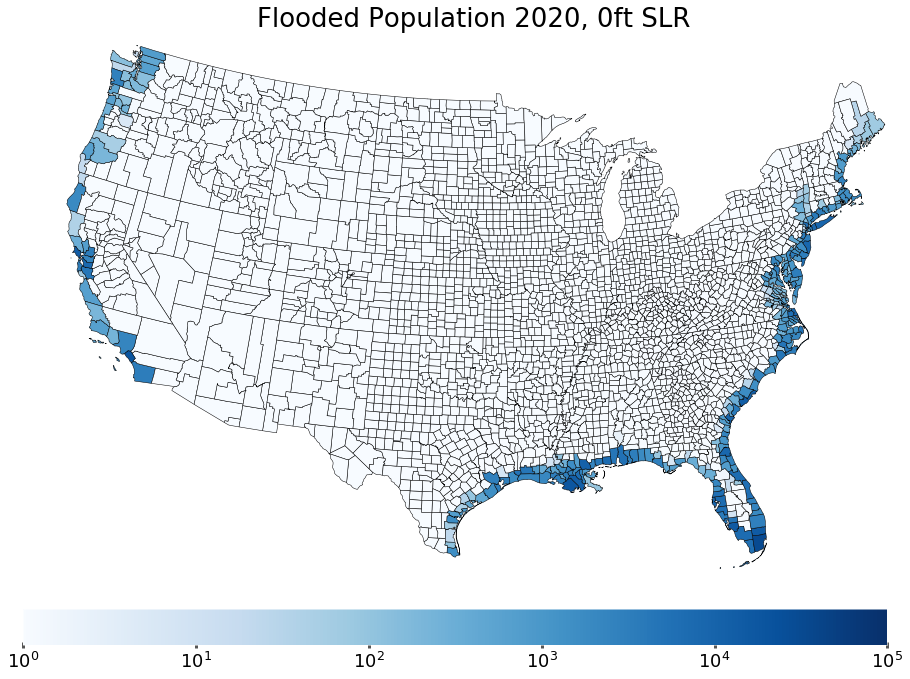

In [12]:
simpleMap(
    shapefileFn,
    shapefileKey,
    vector_to_labeled_dict(flooded_populations[2] - flooded_populations[1], counties),
    #outputFn="examples/demoSimpleFigureNormal.png",
    bounds=[22, 49, -119, -64],
    title="Flooded Population 2020, 0ft SLR",
    colorbarRange=(1, None),
    logScale=True,
)

In [13]:
for i in range(1,len(flood_data)):
    print(np.sum(flooded_populations[i]-flooded_populations[i-1]))

754790.7400273439
609572.093786854
753946.5558711662
1062153.9583670136


## Hauer Results Implementation

In [7]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

In [12]:
# medium
medium_results = []
previously_affected_population = {bg_id: 0.0 for bg_id in block_groups}
for i in range(len(medium_years)):
    print(i)
    population_data = load_bg_population_data(medium_years[i])
    
    affected_population = {}
    for bg_id in block_groups:
        affected_area = 0.0
        if flood_data[i][bg_id] != 1.0:
            affected_area = (float(flood_data[i+1][bg_id]) - float(flood_data[i][bg_id]) ) / (1.0 - flood_data[i][bg_id])
        affected_population[bg_id] = previously_affected_population[bg_id] + ((population_data[bg_id] - previously_affected_population[bg_id]) * affected_area)
    
    medium_results.append(affected_population)
    previously_affected_population = affected_population

0
1
2


In [13]:
# medium
high_results = []
previously_affected_population = {bg_id: 0.0 for bg_id in block_groups}
for i in range(len(high_years)):
    print(i)
    population_data = load_bg_population_data(high_years[i])
    
    affected_population = {}
    for bg_id in block_groups:
        affected_area = 0.0
        if flood_data[i][bg_id] != 1.0:
            affected_area = (float(flood_data[i+1][bg_id]) - float(flood_data[i][bg_id]) ) / (1.0 - flood_data[i][bg_id])
        affected_population[bg_id] = previously_affected_population[bg_id] + ((population_data[bg_id] - previously_affected_population[bg_id]) * affected_area)
    
    high_results.append(affected_population)
    previously_affected_population = affected_population

0
1
2
3
4
5


In [16]:
sum_medium_results = []
sum_high_results = []

for i in range(len(medium_years)):
    sum_medium_results.append(np.sum(list(medium_results[i].values())))
    
for i in range(len(high_years)):
    sum_high_results.append(np.sum(list(high_results[i].values())))

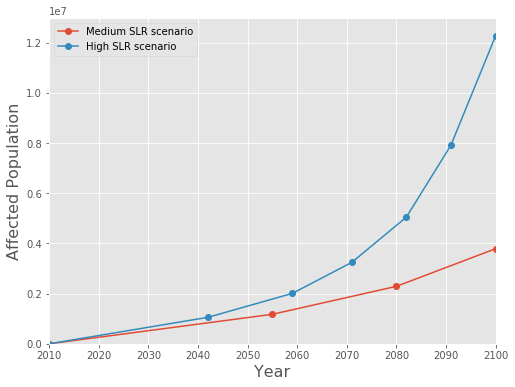

In [21]:
plt.figure(figsize=(8,6))

plt.plot([2010] + medium_years, [0] + sum_medium_results, label="Medium SLR scenario", marker="o")
plt.plot([2010] + high_years, [0] + sum_high_results, label="High SLR scenario", marker="o")

plt.legend(loc="best")

plt.xlim([2010,2100])
plt.ylim([0, 1.3e7])

plt.xlabel("Year", fontsize=16)
plt.ylabel("Affected Population", fontsize=16)

plt.show()
plt.close()